In [1]:
import torch 
import torch.nn as nn
from torch.autograd import grad
from torch.autograd import Variable
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn  as sns
np.random.seed(int(time.time()))
torch.manual_seed(int(time.time()))
device = torch.device("cpu")
print(torch.__version__)
print(torch.cuda.is_available())

1.11.0+cu113
False


In [5]:

class GP_1d(nn.Module):
    def __init__(self,
                nugget_size = 1e-6,
                lengthscale=0.2,
                noise_level = 0.05,
                sigma = 1,
                M = 10,
                device = device,
                 exact_func=None,
                 partial = False):

        super(GP_1d, self).__init__()

        self.device = device
        self.nugget_size = nugget_size
        self.M = M
        self.lengthscale = nn.Parameter(torch.tensor([lengthscale],dtype=torch.float64), requires_grad=True)
        self.noise_level = nn.Parameter(torch.tensor([noise_level],dtype=torch.float64), requires_grad=True)
        
        self.sigma = nn.Parameter(torch.tensor([sigma],dtype=torch.float64), requires_grad=True)
        
        
        
        if exact_func == None:
             def exact_func(x):
                return torch.cos(torch.pi*x)+0.2*torch.sin(10*torch.pi*x)
             self.exact_func = exact_func
        else:
            self.exact_func = exact_func

        Xs = np.random.uniform(-1,1,self.M).reshape(-1,1)
        self.Xs = torch.tensor(Xs,dtype=torch.float64,device=self.device,requires_grad=True)
        
        if partial ==True:
            left = np.random.uniform(-1,-0.2,int(0.5*self.M)).reshape(-1,1)
            right = np.random.uniform(0.5,1.0,int(0.5*self.M)).reshape(-1,1)
            self.Xs = torch.tensor(np.concatenate((left,right),axis=0),dtype = torch.float64,device = self.device,requires_grad=True).view(-1,1)
       
        self.Ys = self.exact_func(self.Xs).detach()
        self.Ys = self.Ys + noise_level*torch.randn_like(self.Ys)*self.Ys
        
    # Covariance function
    def K(self, x, y):
        
        return (self.sigma**2)*torch.exp(-0.5*((self.lengthscale**(-2))*(x-y)**2))

    # For vectorized calculation
    def K11(self,x ,y):
        xcombo = x.repeat(1,y.shape[1])
        ycombo = y.repeat(x.shape[0],1)
        
        return self.K(xcombo,ycombo)

    # Construct K
    def make_Theta(self):
        self.nugget = (self.noise_level**2)*torch.eye(self.M,dtype = torch.float64,device = self.device)

        Theta = self.K11(self.Xs,self.Xs.swapaxes(0,1))+self.nugget
        
        return Theta

    # Negative Log Likelihood
    def loss_func(self):

        Theta = self.make_Theta()

        L = torch.linalg.cholesky(Theta)

        LinvY = torch.linalg.solve(L,self.Ys).squeeze()

        return 0.5*2*torch.log(torch.sum(torch.diagonal(L,0)))+0.5*torch.dot(LinvY,LinvY)

    # Posterior mean
    def predict_mean(self,x):
        
        x = x.clone()
        predK11= self.K11(x,self.Xs.swapaxes(0,1))
        
        Theta = self.make_Theta()
        L = torch.linalg.cholesky(Theta)
    
        return torch.matmul(predK11,torch.linalg.solve(L.T,torch.linalg.solve(L,self.Ys)))
        
    # Posterior variance
    def predict_variance(self,x):
        
        x = x.clone()
        q_u = self.K11(x,self.Xs.swapaxes(0,1))

        Theta = self.make_Theta()
        L = torch.linalg.cholesky(Theta)
    
        temp = torch.linalg.solve(L,q_u.T)
        
        return self.K(x,x)-torch.diag(temp.T@temp).view(-1,1)

    
    

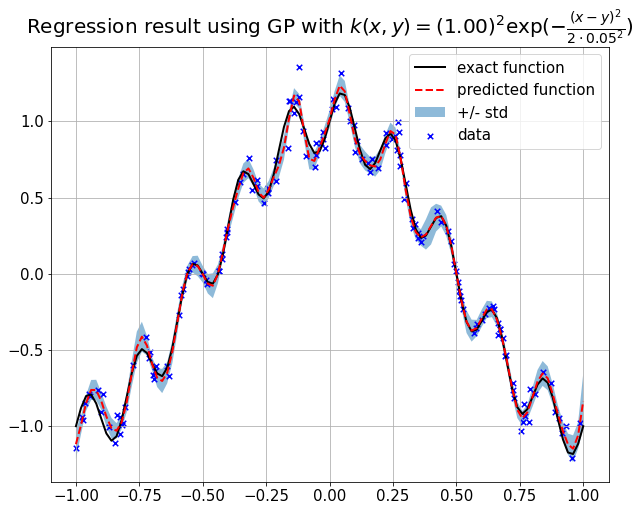

In [10]:
M = 150
model = GP_1d(M = M,lengthscale=0.05,sigma=1,noise_level = 0.1,exact_func = None).to(device).double()


X = torch.linspace(-1,1,101,dtype = torch.float64).view(-1,1)
mean = model.predict_mean(X.to(device)).cpu()
variance = model.predict_variance(X.to(device)).cpu()
lb = mean - 1*torch.sqrt(variance)
ub = mean + 1*torch.sqrt(variance)
with torch.no_grad():
    plt.figure(figsize=(10,8),facecolor='white')
    plt.plot(X,model.exact_func(X),'k',linewidth = 2,label="exact function")
    
    plt.title(f"Regression result using GP with $k(x,y)=({{{model.sigma.item():.2f}}})^2\\exp(-\\frac{{(x-y)^2}}{{2\\cdot{{{model.lengthscale.item():.2f}}}^2}})$",fontsize=20)
    
    plt.plot(X,mean,'--r',label="predicted function",linewidth = 2)
    plt.fill_between(X.flatten(),lb.flatten(),ub.flatten(),alpha=0.5,label='+/- std')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.scatter(model.Xs.cpu().flatten(),model.Ys.cpu().flatten(),c='b',label="data",s=30,marker='x')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()
    # plt.savefig("regression_complex_func.png",bbox_inches='tight')

In [11]:
optimizer = torch.optim.LBFGS(model.parameters(),lr = 1,max_iter=1, history_size=100,line_search_fn ='strong_wolfe')
#torch.autograd.set_detect_anomaly(True)

loss_LBFGS = []
total_start = time.time()
for _ in range(40000):
    start = time.time()
    
    
    def closure():
        
        # Zero gradients
        optimizer.zero_grad()
        loss = model.loss_func()
        # Backward pass
        loss.backward(retain_graph=False) # retain_graph=True
        
        return loss
    optimizer.step(closure)
    loss = closure()
    
    loss_LBFGS.append(loss.item())
    
    
    end = time.time()
    print(f"Iter: {_}, Loss: {loss_LBFGS[_]} Training time: {end-start} seconds")
    if _>0 and loss_LBFGS[_]==loss_LBFGS[_-1]:
        break
total_end = time.time()
print(f"Total Time Cost:{total_end- total_start}")

Iter: 0, Loss: 9.27260499465758 Training time: 0.02031111717224121 seconds
Iter: 1, Loss: 8.843774772987127 Training time: 0.04841041564941406 seconds
Iter: 2, Loss: 7.7446422000108015 Training time: 0.016548633575439453 seconds
Iter: 3, Loss: 7.1918185843726175 Training time: 0.016597270965576172 seconds
Iter: 4, Loss: 6.802430616609066 Training time: 0.01613140106201172 seconds
Iter: 5, Loss: 6.59088055507081 Training time: 0.023682594299316406 seconds
Iter: 6, Loss: 6.472365801891311 Training time: 0.016021251678466797 seconds
Iter: 7, Loss: 6.407166261799305 Training time: 0.015523910522460938 seconds
Iter: 8, Loss: 6.398672617242247 Training time: 0.015986204147338867 seconds
Iter: 9, Loss: 6.354629118360914 Training time: 0.015609264373779297 seconds
Iter: 10, Loss: 6.343801631779039 Training time: 0.02267289161682129 seconds
Iter: 11, Loss: 6.332244549126141 Training time: 0.016040563583374023 seconds
Iter: 12, Loss: 6.318882046141158 Training time: 0.017197847366333008 seconds


noise_level_learned: 1.9865060560853574


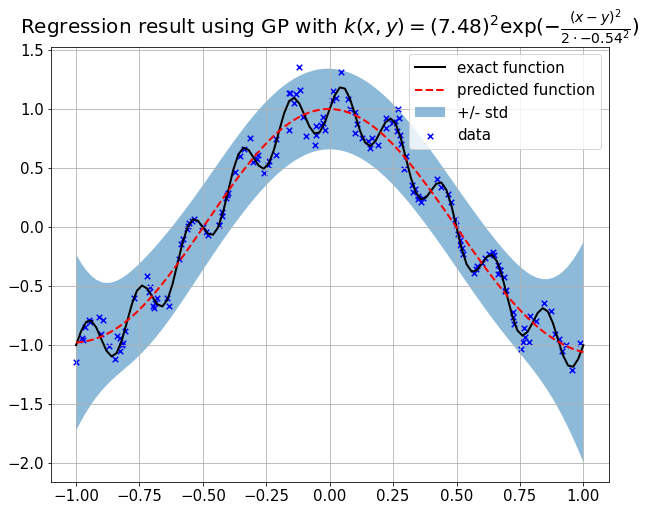

In [12]:
X = torch.linspace(-1,1,101,dtype = torch.float64).view(-1,1)
mean = model.predict_mean(X.to(device)).cpu()
variance = model.predict_variance(X.to(device)).cpu()
lb = mean - 1*torch.sqrt(variance)
ub = mean + 1*torch.sqrt(variance)
print("noise_level_learned:",model.noise_level.item())
with torch.no_grad():
    plt.figure(figsize=(10,8),facecolor='white')
    plt.plot(X,model.exact_func(X),'k',linewidth = 2,label="exact function")
    
    plt.title(f"Regression result using GP with $k(x,y)=({{{model.sigma.item():.2f}}})^2\\exp(-\\frac{{(x-y)^2}}{{2\\cdot{{{model.lengthscale.item():.2f}}}^2}})$",fontsize=20)
    
    plt.plot(X,mean,'--r',label="predicted function",linewidth = 2)
    plt.fill_between(X.flatten(),lb.flatten(),ub.flatten(),alpha=0.5,label='+/- std')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.scatter(model.Xs.cpu().flatten(),model.Ys.cpu().flatten(),c='b',label="data",s=30,marker='x')
    plt.legend(fontsize=15)
    plt.grid()
    # plt.show()
    plt.savefig("regression_complex_func.png",bbox_inches='tight')

In [13]:
def exact_func(x):
    return torch.cos(torch.pi*x)+x**2-x

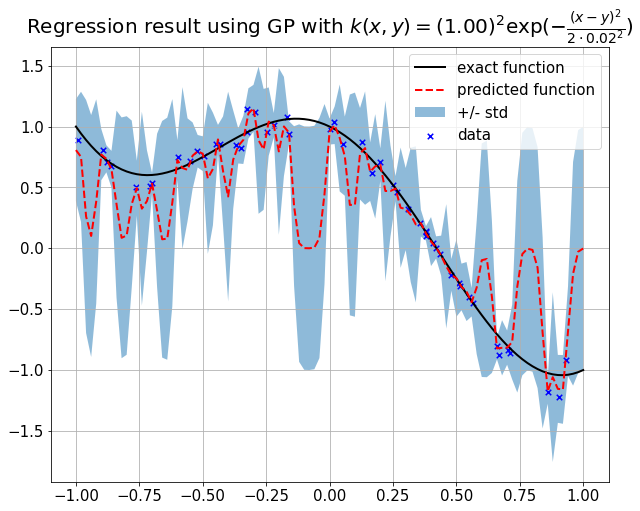

In [14]:
M = 50
model = GP_1d(M = M,lengthscale=0.02,sigma=1,noise_level = 0.1,exact_func = exact_func).to(device).double()


X = torch.linspace(-1,1,101,dtype = torch.float64).view(-1,1)
mean = model.predict_mean(X.to(device)).cpu()
variance = model.predict_variance(X.to(device)).cpu()
lb = mean - 1*torch.sqrt(variance)
ub = mean + 1*torch.sqrt(variance)
with torch.no_grad():
    plt.figure(figsize=(10,8),facecolor='white')
    plt.plot(X,model.exact_func(X),'k',linewidth = 2,label="exact function")
    
    plt.title(f"Regression result using GP with $k(x,y)=({{{model.sigma.item():.2f}}})^2\\exp(-\\frac{{(x-y)^2}}{{2\\cdot{{{model.lengthscale.item():.2f}}}^2}})$",fontsize=20)
    
    plt.plot(X,mean,'--r',label="predicted function",linewidth = 2)
    plt.fill_between(X.flatten(),lb.flatten(),ub.flatten(),alpha=0.5,label='+/- std')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.scatter(model.Xs.cpu().flatten(),model.Ys.cpu().flatten(),c='b',label="data",s=30,marker='x')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

In [15]:
optimizer = torch.optim.LBFGS(model.parameters(),lr = 1,max_iter=1, history_size=100,line_search_fn ='strong_wolfe')
#torch.autograd.set_detect_anomaly(True)

loss_LBFGS = []
total_start = time.time()
for _ in range(40000):
    start = time.time()
    
    
    def closure():
        
        # Zero gradients
        optimizer.zero_grad()
        loss = model.loss_func()
        # Backward pass
        loss.backward(retain_graph=False) # retain_graph=True
        
        return loss
    optimizer.step(closure)
    loss = closure()
    
    loss_LBFGS.append(loss.item())
    
    
    end = time.time()
    print(f"Iter: {_}, Loss: {loss_LBFGS[_]} Training time: {end-start} seconds")
    if _>0 and loss_LBFGS[_]==loss_LBFGS[_-1]:
        break
total_end = time.time()
print(f"Total Time Cost:{total_end- total_start}")

Iter: 0, Loss: 10.434465472061092 Training time: 0.0055828094482421875 seconds
Iter: 1, Loss: 6.446202690143988 Training time: 0.0035810470581054688 seconds
Iter: 2, Loss: 6.202409361134 Training time: 0.0042667388916015625 seconds
Iter: 3, Loss: 5.636493244232398 Training time: 0.004514455795288086 seconds
Iter: 4, Loss: 5.311791912493732 Training time: 0.004496574401855469 seconds
Iter: 5, Loss: 4.983029281591949 Training time: 0.004800319671630859 seconds
Iter: 6, Loss: 4.73898051540327 Training time: 0.0035262107849121094 seconds
Iter: 7, Loss: 4.570392577260468 Training time: 0.0034911632537841797 seconds
Iter: 8, Loss: 4.455938696555181 Training time: 0.0034415721893310547 seconds
Iter: 9, Loss: 4.385589878982225 Training time: 0.003438711166381836 seconds
Iter: 10, Loss: 4.36080093530046 Training time: 0.003759145736694336 seconds
Iter: 11, Loss: 4.355707201927168 Training time: 0.0038433074951171875 seconds
Iter: 12, Loss: 4.354896461092075 Training time: 0.003506183624267578 s

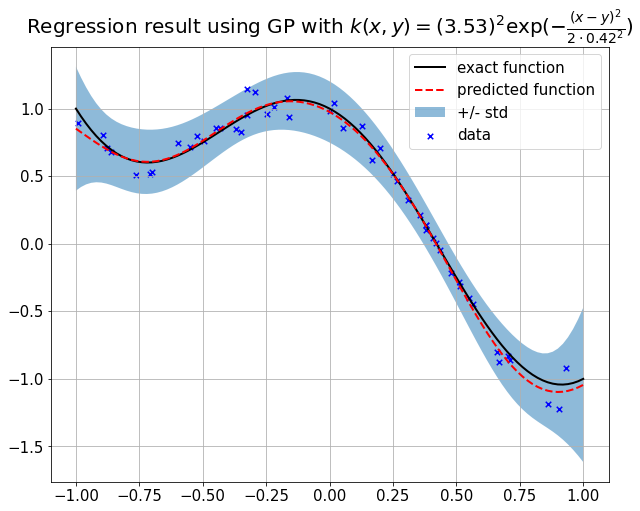

In [16]:
M = 50
# model = GP_1d(M = M,lengthscale=0.2,sigma=1,noise_level = 0.1,exact_func = exact_func).to(device).double()


X = torch.linspace(-1,1,101,dtype = torch.float64).view(-1,1)
mean = model.predict_mean(X.to(device)).cpu()
variance = model.predict_variance(X.to(device)).cpu()
lb = mean - 1*torch.sqrt(variance)
ub = mean + 1*torch.sqrt(variance)
with torch.no_grad():
    plt.figure(figsize=(10,8),facecolor='white')
    plt.plot(X,model.exact_func(X),'k',linewidth = 2,label="exact function")
    
    plt.title(f"Regression result using GP with $k(x,y)=({{{model.sigma.item():.2f}}})^2\\exp(-\\frac{{(x-y)^2}}{{2\\cdot{{{model.lengthscale.item():.2f}}}^2}})$",fontsize=20)
    
    plt.plot(X,mean,'--r',label="predicted function",linewidth = 2)
    plt.fill_between(X.flatten(),lb.flatten(),ub.flatten(),alpha=0.5,label='+/- std')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.scatter(model.Xs.cpu().flatten(),model.Ys.cpu().flatten(),c='b',label="data",s=30,marker='x')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

In [ ]:
M = 50
model = GP_1d(M = M,lengthscale=0.03,sigma=1,noise_level = 0.05,exact_func = exact_func,partial = True).to(device).double()


X = torch.linspace(-1,1,101,dtype = torch.float64).view(-1,1)
mean = model.predict_mean(X.to(device)).cpu()
variance = model.predict_variance(X.to(device)).cpu()
lb = mean - 1*torch.sqrt(variance)
ub = mean + 1*torch.sqrt(variance)
with torch.no_grad():
    plt.figure(figsize=(10,8),facecolor='white')
    plt.plot(X,model.exact_func(X),'k',linewidth = 2,label="exact function")
    
    plt.title(f"Regression result using GP with $k(x,y)=({{{model.sigma.item():.2f}}})^2\\exp(-\\frac{{(x-y)^2}}{{2\\cdot{{{model.lengthscale.item():.2f}}}^2}})$",fontsize=20)
    
    plt.plot(X,mean,'--r',label="predicted function",linewidth = 2)
    plt.fill_between(X.flatten(),lb.flatten(),ub.flatten(),alpha=0.5,label='+/- std')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.scatter(model.Xs.cpu().flatten(),model.Ys.cpu().flatten(),c='b',label="data",s=30,marker='x')
    plt.legend(fontsize=15)
    plt.grid()
    # plt.show()
    plt.savefig("regression_partial.png",bbox_inches='tight')

In [ ]:
optimizer = torch.optim.LBFGS(model.parameters(),lr = 1,max_iter=1, history_size=100,line_search_fn ='strong_wolfe')
#torch.autograd.set_detect_anomaly(True)

loss_LBFGS = []
total_start = time.time()
for _ in range(40000):
    start = time.time()
    
    
    def closure():
        
        # Zero gradients
        optimizer.zero_grad()
        loss = model.loss_func()
        # Backward pass
        loss.backward(retain_graph=False) # retain_graph=True
        
        return loss
    optimizer.step(closure)
    loss = closure()
    
    loss_LBFGS.append(loss.item())
    
    
    end = time.time()
    print(f"Iter: {_}, Loss: {loss_LBFGS[_]} Training time: {end-start} seconds")
    if _>0 and loss_LBFGS[_]==loss_LBFGS[_-1]:
        break
total_end = time.time()
print(f"Total Time Cost:{total_end- total_start}")

In [ ]:
X = torch.linspace(-1,1,101,dtype = torch.float64).view(-1,1)
mean = model.predict_mean(X.to(device)).cpu()
variance = model.predict_variance(X.to(device)).cpu()
lb = mean - 1*torch.sqrt(variance)
ub = mean + 1*torch.sqrt(variance)
with torch.no_grad():
    plt.figure(figsize=(10,8),facecolor='white')
    plt.plot(X,model.exact_func(X),'k',linewidth = 2,label="exact function")
    
    plt.title(f"Regression result using GP with $k(x,y)=({{{model.sigma.item():.2f}}})^2\\exp(-\\frac{{(x-y)^2}}{{2\\cdot{{{model.lengthscale.item():.2f}}}^2}})$",fontsize=20)
    
    plt.plot(X,mean,'--r',label="predicted function",linewidth = 2)
    plt.fill_between(X.flatten(),lb.flatten(),ub.flatten(),alpha=0.5,label='+/- std')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.scatter(model.Xs.cpu().flatten(),model.Ys.cpu().flatten(),c='b',label="data",s=30,marker='x')
    plt.legend(fontsize=15)
    plt.grid()
    # plt.show()
    plt.savefig("regression_partial.png",bbox_inches='tight')